# Basic Monte Carlo techniques
## Hard disks in a square

Consider a system of $N$ identical hard disks with diameter $1$ in a square of size $10$.
The use of periodic boundary conditions can be switched on or off.
The energy of this system ($U$) is either $U=0$ (no overlaps) or $U=\infty$ (at least one overlap).
We would like to calculate the radial distribution function of the disks ($g\left(r\right), \,\,r <5$) in the canonical ensemble.
There are 2 methods of calculating this:

1. Dynamic scheme: the disks are initially placed on a lattice and trial moves are performed to translate the disks.
A trial move is accepted when there are no overlaps and rejected when there are one or more overlaps.
2. Static Scheme: in every cycle, all disks are put at a completely random position in the system.
The radial distribution function of this configuration is calculated and multiplied by the Boltzmann factor of the system ($0$ when there is at least one overlap and $1$ when there are no overlaps).

<span style="padding:30px">
<img src="https://i.postimg.cc/hPcc61j0/hard-disk1.png" width="300" height="300"/><img src="https://i.postimg.cc/hPcc61j0/hard-disk2.png" width="300" height="300"/>
</span>

*Eighteen hard disks in a box.
The blue particles constitute the old system, the green particles the new system.
The dynamic scheme performs a displacement trial move in one of the particles.
The move is rejected when there is a overlap.
The static scheme puts all particles at new random positions in the system.
The move is accepted when there is no overlap.*

1. Write a program to perform a Monte Carlo simulation of hard disks in a square.
Code to initialise the configurations and to compute the system energy has been written for you.
Calculate $g{(r)}$ using both the static and dynamic approaches.
Make sure that both methods give the same result when $N$ is small.

HINT: ensure that your code correctly reproduces $g{(r)}$ for the ideal gas.

In [1]:
# !pip install --upgrade cython
%reload_ext Cython

In [2]:
%%cython

from cython.cimports.libc.math import sqrt, rint, INFINITY
import cython
import numpy as np

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def hard_disks_energy(xs: cython.double[:, ::1], box_length: cython.double) -> float:
    """
    Compute the energy of a system of hard disks in a square.
    """
    particles = xs.shape[0]
    dimensions = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    energy = 0.0

    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rijd = xs[i, d] - xs[j, d]
                rijd -= rint(rijd / box_length) * box_length
                r2 += rijd * rijd
            if r2 < 1:
                energy = INFINITY
                break
    return energy


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def hard_disks_energy_one(xs: cython.double[:, ::1], i: cython.Py_ssize_t, box_length: cython.double) -> float:
    """
    Compute the energy of the i-th hard disk in a system of hard disks in a square.
    """
    particles = xs.shape[0]
    dimensions = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    energy = 0.0

    for j in range(particles):
        if j == i:
            continue
        r2 = 0.0
        for d in range(dimensions):
            rijd = xs[i, d] - xs[j, d]
            rijd -= rint(rijd / box_length) * box_length
            r2 += rijd * rijd
        if r2 < 1:
            energy = INFINITY
            break
    return energy

In [3]:
from itertools import product


def create_configuration(n_disks: int, box_length: float) -> np.ndarray:
    """ Place some disks on a square lattice. """

    # build the square lattice just big enough to accomodate n_disks
    
    n_per_dimension = int((n_disks-0.5)**0.5) + 1
    
    if n_per_dimension > box_length:
        raise ValueError("can't place that many disks into such a small box!")
    
    grid_points = np.linspace(0, box_length, n_per_dimension, endpoint=False)
    xs = np.array(list(product(grid_points, repeat=2)))
    
    # discard the excess disks
    xs = xs[np.random.choice(range(xs.shape[0]), n_disks, replace=False)]

    assert hard_disks_energy(xs, box_length) == 0
    return xs

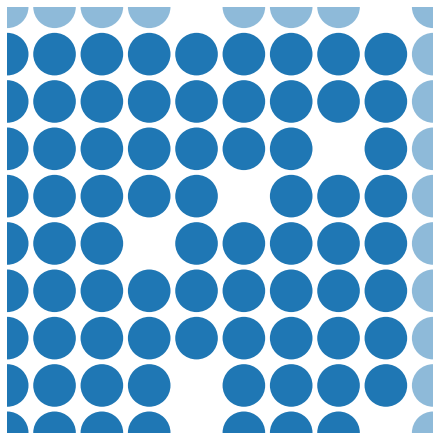

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product


def draw_hard_disks_configuration(xs: np.ndarray, box_length: float, fig: plt.Figure, ax: plt.Axes) -> None:
    for x, y in xs:
        x -= int(x/box_length)*box_length
        y -= int(x/box_length)*box_length
        ax.add_patch(plt.Circle((x, y), 0.5))
        
        for i, j in product((-box_length, 0, box_length), repeat=2):
            x_im = x + i
            y_im = y + j
            if not (i == j == 0) and 0 <= x_im <= box_length and 0 <= y_im <= box_length:
                ax.add_patch(plt.Circle((x_im, y_im), 0.5, alpha=0.5))
    return


if __name__ == "__main__":
    xs = create_configuration(75, 10)
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 6))
    draw_hard_disks_configuration(xs, 10, fig, ax)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_axis_off()
    plt.show()

In [5]:
%%cython

import cython
from cython.cimports.libc.math import sqrt, rint, floor
import numpy as np

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def compute_gr( positions: cython.double[:, ::1], box_length: cython.double, n_bins: cython.int, max_dis: cython.double = 5.0):
    """
    高效计算硬盘系统的径向分布函数 g(r)

    参数:
    positions: 粒子位置数组 (N, 2)
    box_length: 正方形边长
    n_bins: 直方图中的bin数量
    max_dis: 考虑的最大距离

    返回:
    tuple: (bin_centers, g_r_values) - 距离分割点和对应的g(r)值
    """

    cdef int n_particles = positions.shape[0]
    cdef double bin_width = max_dis / n_bins
    cdef double[:] hist = np.zeros(n_bins, dtype=np.float64)
    cdef double[:] bin_edges = np.linspace(0, max_dis, n_bins + 1, dtype=np.float64)
    cdef double[:] bin_centers = np.zeros(n_bins, dtype=np.float64)
    cdef double[:] g_r_values = np.zeros(n_bins, dtype=np.float64)

    cdef int i, j, bin_idx
    cdef double dx, dy, r2, r
    cdef double volume = box_length * box_length
    cdef double rho = n_particles / volume  # 粒子数密度
    cdef double area, expected_count
    cdef double pi = 3.14159265358979323846  # π

    # 计算bin中心
    for i in range(n_bins):
        bin_centers[i] = (bin_edges[i] + bin_edges[i+1]) / 2.0

    # 计算所有粒子对之间的距离
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            # 计算距离（考虑周期性边界条件）
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]

            # 应用最小图像约定
            dx -= rint(dx / box_length) * box_length
            dy -= rint(dy / box_length) * box_length

            r2 = dx * dx + dy * dy
            r = sqrt(r2)

            if r < max_dis:
                bin_idx = <int>floor(r / bin_width)
                # Ensure bin_idx is within bounds
                if bin_idx < n_bins:
                    hist[bin_idx] += 2  # 每个对贡献2次计数（i->j和j->i）

    # 归一化
    for i in range(n_bins):
        # 环的面积: π[(r+dr)²-r²] = π(2r·dr+dr²) ≈ 2πr·dr
        r = bin_centers[i]
        # area = np.pi * (bin_edges[i+1]**2 - bin_edges[i]**2) # More accurate area
        area = 2.0 * pi * r * bin_width # Approximation is fine for small bin_width

        # 理想气体中,该环内期望的粒子数
        # Need normalization factor for pairs: N*(N-1)/2 pairs, but we sum over N particles
        # Normalization should be N * rho * area / 2 (divide by 2 because we count pairs ij and ji implicitly by summing over i)
        # Or simpler: hist counts pairs twice, so normalization is N * rho * area
        # Correction: The normalization factor should be related to the number of pairs N*(N-1)/2,
        # but since g(r) is defined relative to the ideal gas density rho,
        # the normalization factor for the histogram count in a shell is rho * area * N / 2 (for pairs)
        # Since hist counts each pair twice (i->j and j->i), we divide hist by 2.
        # Or, keep hist += 2 and normalize by rho * area * N
        # Let's stick to the common definition: g(r) = (hist[i] / (N * (N-1)/2)) / (rho * area / (N*(N-1)/2)) = hist[i] / (N * rho * area) ? No.
        # Standard normalization: g(r) = V/(N*(N-1)) * <sum_{i!=j} delta(r - r_ij)> / (2*pi*r*dr)
        # In histogram form: g(r) = V/(N*(N-1)) * (hist[i] / (2*pi*r*dr))
        # hist[i] contains counts for pairs (ij) and (ji), so it's double the number of pairs in the bin.
        # Number of pairs = N*(N-1)/2. Average number density = N/V.
        # Ideal gas count in shell = rho * area * N / 2 ? No.
        # Ideal gas count = rho * area * (N-1) / 2 ? No.
        # Ideal gas count = rho * area * N ? No.
        # Let's use the definition from Frenkel & Smit:
        # g(r) = <N(r, dr)> / (rho * 2 * pi * r * dr * N / 2)
        # <N(r, dr)> is the average number of pairs with separation between r and r+dr.
        # Our hist[i] is the count for one configuration, summed over pairs (ij) and (ji).
        # So hist[i]/2 is the number of pairs in the bin for this config.
        # Normalization factor = rho * area * N / 2
        # g_r = (hist[i]/2) / (rho * area * N / 2) = hist[i] / (rho * area * N)

        expected_count = rho * area * n_particles # This is the normalization factor

        # g(r)是实际粒子数与理想气体期望粒子数的比值
        if expected_count > 0:
            # Divide hist by 2 because it counts pairs twice (i->j and j->i)
            # g_r_values[i] = (hist[i] / 2.0) / expected_count # This seems wrong based on standard defs
            # Let's use the definition: g(r) = V/(N*(N-1)) * hist[i] / area
            # where hist[i] is the count of pairs (not double counted)
            # Since our hist counts pairs twice, use hist[i]/2
            # g_r = V / (N * (N-1)) * (hist[i]/2) / area
            # This assumes N is large, often N*(N-1) is approximated by N^2
            # g_r approx V/N^2 * (hist[i]/2) / area = 1/(rho*N) * (hist[i]/2) / area
            # Let's try the common simulation practice:
            # Normalize by the number of ideal gas particles in the shell * number of particles
            # Ideal gas density in shell = rho * area
            # Number of particles = N
            # Normalization = rho * area * N
            # Since hist counts pairs twice, divide by 2?
            # Let's try: norm = rho * area * N / 2.0
            # g_r = (hist[i]/2.0) / norm = hist[i] / (rho * area * N)
            # This matches the previous derivation.

            g_r_values[i] = hist[i] / (rho * area * n_particles)


    return np.asarray(bin_centers), np.asarray(g_r_values)

# ... rest of the cell ...

In [9]:
def g_r(xs: np.ndarray, box_length: float, n_bins: int, max_dis=5) -> tuple:
    """
    计算硬盘系统的径向分布函数g(r)。
    
    参数:
    xs: 粒子位置数组
    box_length: 正方形边长
    n_bins: 直方图中的bin数量
    max_dis: 考虑的最大距离
    
    返回:
    tuple: (r_values, g_r_values) - 距离值和对应的g(r)值
    """
    return compute_gr(xs, box_length, n_bins, max_dis)

def dynamic_mc(n_particles, box_length, n_steps, delta=0.1):
    """动态Monte Carlo方法"""
    # 初始化粒子位置（在格子上）
    positions = create_configuration(n_particles, box_length)
    
    # 收集g(r)样本的数组
    n_bins = 100
    r_bins = np.zeros(n_bins)
    gr_bins = np.zeros(n_bins)
    samples = 0
    
    # 执行MC步骤
    for step in range(n_steps):
        # 随机选择一个粒子
        i = np.random.randint(0, n_particles)
        old_pos = positions[i].copy()
        
        # 尝试移动
        positions[i, 0] += (np.random.random() - 0.5) * 2 * delta
        positions[i, 1] += (np.random.random() - 0.5) * 2 * delta
        
        # 应用周期性边界条件
        positions[i, 0] %= box_length
        positions[i, 1] %= box_length
        
        # 检查能量（是否有重叠）
        if hard_disks_energy_one(positions, i, box_length) == float('inf'):
            # 拒绝移动
            positions[i] = old_pos
        
        # 每隔一定步数计算一次g(r)
        if step % 10 == 0 and step > 1000:  # 跳过平衡阶段
            r, gr = g_r(positions, box_length, n_bins)
            r_bins = r
            gr_bins += gr
            samples += 1
    
    # 计算平均g(r)
    if samples > 0:
        gr_bins /= samples
    
    return r_bins, gr_bins

def static_mc(n_particles, box_length, n_steps):
    """静态Monte Carlo方法"""
    n_bins = 100
    r_bins = np.zeros(n_bins)
    gr_bins = np.zeros(n_bins)
    accepted = 0
    
    for step in range(n_steps):
        # 随机放置所有粒子
        positions = np.random.random((n_particles, 2)) * box_length
        
        # 检查能量（是否有重叠）
        energy = hard_disks_energy(positions, box_length)
        
        # 如果没有重叠，接受这个构型并计算g(r)
        if energy < float('inf'):
            r, gr = g_r(positions, box_length, n_bins)
            r_bins = r
            gr_bins += gr
            accepted += 1
    
    # 计算平均g(r)
    if accepted > 0:
        gr_bins /= accepted
    
    return r_bins, gr_bins, accepted/n_steps

def main():
    """主函数：运行模拟并绘制结果"""
    n_particles = 75  # 粒子数量
    box_length = 10.0  # 正方形边长
    
    # 动态MC方法
    r_dynamic, gr_dynamic = dynamic_mc(n_particles, box_length, n_steps=1000000, delta=0.2)
    
    # 静态MC方法
    r_static, gr_static, acceptance = static_mc(n_particles, box_length, n_steps=1000000)
    
    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.plot(r_dynamic, gr_dynamic, 'b-', label='Dynamic MC')
    plt.plot(r_static, gr_static, 'r--', label='Static MC')
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.grid(True)
    plt.legend()
    plt.title(f'Radial Distribution Function for N={n_particles} hard disks')
    plt.show()
    
    print(f"Static MC acceptance rate: {acceptance:.4f}")

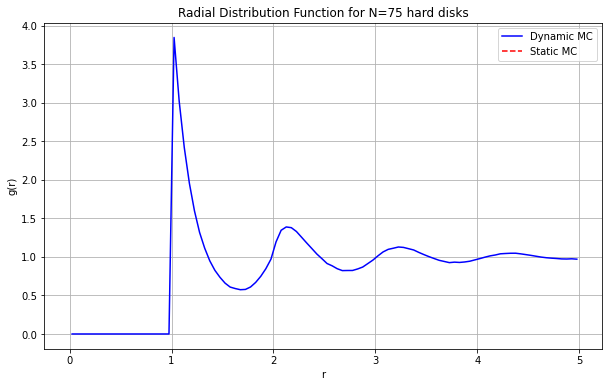

Static MC acceptance rate: 0.0000


In [10]:
main()

2. At which $N$ does the second method start to fail? Why?

Static MC acceptance rate for 10 particles: 0.2199
Static MC acceptance rate for 15 particles: 0.0260
Static MC acceptance rate for 20 particles: 0.0011
Static MC acceptance rate for 25 particles: 0.0000


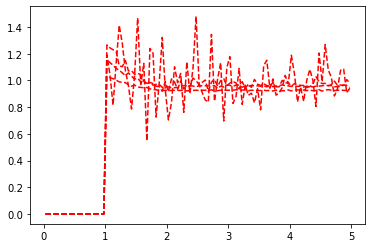

In [26]:
box_length = 10.0
plt.figure()
for n_particles in np.arange(10, 30, 5):
    r_static, gr_static, acceptance = static_mc(n_particles, box_length, n_steps=1000000)
    plt.plot(r_static, gr_static, 'r--', label='Static MC')
    print(f"Static MC acceptance rate for {n_particles} particles: {acceptance:.4f}")

3. For which method will there be a larger correlation between successive elements of the Markov chain? Explain.

4. Switch off the periodic boundary condition.
What part of the radial distribution function changes the most? Why?

Static MC acceptance rate for box length 10: 0.0011
Static MC acceptance rate for box length 13: 0.0222
Static MC acceptance rate for box length 16: 0.0859
Static MC acceptance rate for box length 19: 0.1804


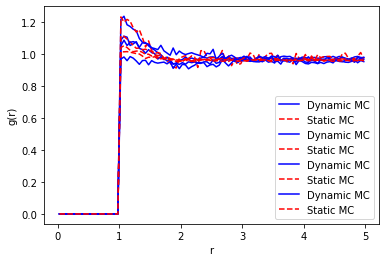

In [27]:
n_particles = 20  # 粒子数量
box_lengths = np.arange(10,20,3)
plt.figure()
for box_length in box_lengths:
    r_dynamic, gr_dynamic = dynamic_mc(n_particles, box_length, n_steps=1000000, delta=0.2)
    plt.plot(r_dynamic, gr_dynamic, 'b-', label='Dynamic MC')
    r_static, gr_static, acceptance = static_mc(n_particles, box_length, n_steps=1000000)

    plt.plot(r_static, gr_static, 'r--', label='Static MC')
    print(f"Static MC acceptance rate for box length {box_length}: {acceptance:.4f}")

plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()